***
# **Image Classification Using ResNets**
### Deep Learning Course Project
***
I have used `intel-image-classification` dataset for this course project. It has classes like of images like `buildings, forest, glacier, mountain, sea, street` each containing images of shape of `150 x 150` pixels. The task is to classify this images and train a model to predict any previously unseen images which belongs to one of these classes with max accuracy using `deep neural network`, `CNN` and `ResNets` (Here, ResNet9).

# ;)

First the necessary imports!

In [2]:
# !pip install jovian --upgrade --quiet

In [3]:
import os
import torch
import jovian
import torchvision
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from torch.utils.data import random_split
from torchvision.transforms import ToTensor
from torchvision.datasets import ImageFolder
from torchvision.utils import make_grid

In [4]:
project_name = "deep-learning-course-project-resnet"

In [5]:
%matplotlib inline

matplotlib.rcParams['figure.facecolor'] = '#ffffff'

In Google Colab, if we want to use a dataset from kaggle, we have to -
1. Create a folder named `.kaggle` in root directory.
2. Copy `kaggle.json` file downloaded from `kaggle.com (API file)` to `.kaggle` folder.
3. Download dataset using that dataset's API downlaod command.<br>
    Ex., `kaggle datasets download -d dataset_path (author_dataset-name)`
4. Unzip files if in compressed format.


In [6]:
!mkdir ../root/.kaggle
!echo '{"username":"pratikghodke","key":"125c78ba22db1051c22216e23fd0cd2d"}' > ../root/.kaggle/kaggle.json
!kaggle datasets download -d puneet6060/intel-image-classification
!ls
!unzip \*.zip  && rm *.zip

Streaming output truncated to the last 5000 lines.
  inflating: seg_train/seg_train/mountain/7506.jpg  
  inflating: seg_train/seg_train/mountain/7537.jpg  
  inflating: seg_train/seg_train/mountain/7539.jpg  
  inflating: seg_train/seg_train/mountain/7551.jpg  
  inflating: seg_train/seg_train/mountain/7560.jpg  
  inflating: seg_train/seg_train/mountain/7565.jpg  
  inflating: seg_train/seg_train/mountain/7578.jpg  
  inflating: seg_train/seg_train/mountain/7581.jpg  
  inflating: seg_train/seg_train/mountain/7586.jpg  
  inflating: seg_train/seg_train/mountain/7647.jpg  
  inflating: seg_train/seg_train/mountain/7652.jpg  
  inflating: seg_train/seg_train/mountain/7654.jpg  
  inflating: seg_train/seg_train/mountain/7662.jpg  
  inflating: seg_train/seg_train/mountain/767.jpg  
  inflating: seg_train/seg_train/mountain/7672.jpg  
  inflating: seg_train/seg_train/mountain/7679.jpg  
  inflating: seg_train/seg_train/mountain/7681.jpg  
  inflating: seg_train/seg_train/mountain/7693.jp

We have downloaded and extracted files successfully !

In [7]:
base_dir = '.'
os.listdir(base_dir)

['.config', 'seg_pred', 'seg_test', 'seg_train', 'sample_data']

In kaggle notebooks, there is no need to go with procedure like we have to do in Google Colab. We can directly use datasets in kaggle notebooks !

In [8]:
# base_dir = '../input/intel-image-classification'
# os.listdir(base_dir)

Since, kaggle GPU has time limits, I did most of my work on Google Colab.

***
# Data Preparation
***

Now, we have to play with our data ... <br>
For the purpose of reducing overfitting we have to make some changes in our data. I have used following methods to deal with such data -
1. `Resizing data` (Since, not every image was in 150 x 150 shape)
2. Croping Random `150 x 150` pixel image after applying `padding=4` which makes image shape equal to `158 x 158` pixels.
3. If there's some black portion i.e. portion from padding, we replace those pixels with random Horizontal pixels creating `mirror like reflection`.
4. Converting to `tensor format`.
5. Normalize all values so that they lies in range `-1 to 1` using `means` and `standard deviations` for every channel.

In [9]:
import torchvision.transforms as tt

# stats = ((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
stats = ((0.4300, 0.4571, 0.4533), (0.2581, 0.2563, 0.2886))

train_tt = tt.Compose([
    tt.Resize((130, 130)),
    tt.RandomCrop(130, padding = 4, padding_mode = 'reflect'),
    tt.RandomHorizontalFlip(),
    tt.ToTensor(),
    tt.Normalize(*stats, inplace = True)
])

val_tt = tt.Compose([
    tt.Resize((130, 130)),
    tt.ToTensor(),
    tt.Normalize(*stats)
])

Applying tranforms we created in previous cell to our datasets.

In [10]:
train_set = ImageFolder(base_dir+'/seg_train/seg_train', transform=train_tt)
val_set = ImageFolder(base_dir+'/seg_test/seg_test', transform=val_tt)

print("Classes in dataset :", train_set.classes)

Classes in dataset : ['buildings', 'forest', 'glacier', 'mountain', 'sea', 'street']


Deciding `batch_size` to import dataset as chunk of data rather importing whole data.

In [11]:
batch_size = 128

In [12]:
from torch.utils.data import DataLoader

train_dl = DataLoader(train_set, batch_size, shuffle=True, num_workers=4, pin_memory=True)
val_dl = DataLoader(val_set, batch_size*2, num_workers=4, pin_memory=True)

Let's see how our batch actully looks.<br>
We are gonna denormalize image data to see its original form.

In [13]:
def denormalize(imgs, means, stds):
    means = torch.tensor(means).reshape(1,3,1,1)
    stds  = torch.tensor(stds).reshape(1,3,1,1)
    return imgs * stds + means

def show_batch(dl):
    for imgs, labels in dl:
        print(imgs.shape)
        fig, ax = plt.subplots(figsize=(18,9))
        ax.set_xticks([])
        ax.set_yticks([])
        denorm_imgs = denormalize(imgs, *stats)
        plt.imshow(make_grid(denorm_imgs[:64], nrow=8).permute(1,2,0).clamp(0,1))
        break

torch.Size([128, 3, 130, 130])


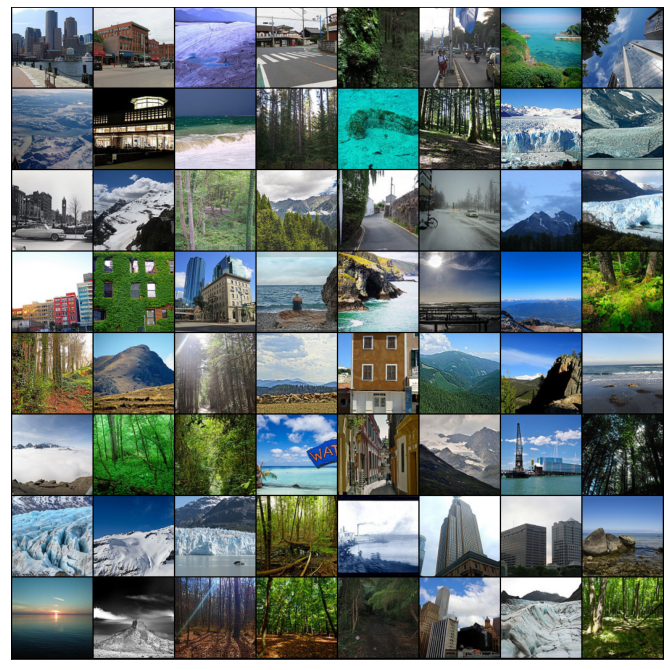

In [14]:
show_batch(train_dl)

Below are some functions that will allow us to decide better device to work on (CPU / GPU) and functionality to move data from one device to another.

In [15]:
def get_default_device():
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
    
def to_device(data, device):
    if isinstance(data, (list, tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        for b in self.dl:
            yield to_device(b, self.device)
            
    def __len__(self):
        return len(self.dl)

In [16]:
device = get_default_device()
device

device(type='cuda')

Looks like we have `cuda GPU` available to work on. So, we are going to use GPU for better training performance.

In [17]:
train_dl = DeviceDataLoader(train_dl, device)
val_dl = DeviceDataLoader(val_dl, device)

***
# Training
***

Below cell contains -
1. `accuracy` function which calculated accuracy of prediction.
2. A Class `ImageClassificationBase` which extends `nn.Module` and has basic model functionality like training, validating, and some metrics like average loss, accuaracy.

In [18]:
import torch.nn as nn
import torch.nn.functional as F

def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

class ImageClassificationBase(nn.Module):
    def training_step(self, batch):
        imgs, labels = batch 
        out = self(imgs)                  
        loss = F.cross_entropy(out, labels) 
        return loss
    
    def validation_step(self, batch):
        imgs, labels = batch 
        out = self(imgs)                    
        loss = F.cross_entropy(out, labels)   
        acc = accuracy(out, labels)           
        return {'val_loss': loss.detach(), 'val_acc': acc}
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()

        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
    def epoch_end(self, epoch, result):
        print(
            "Epoch [{}], last_lr: {:.5f}, train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
                epoch, result['lrs'][-1],
                result['train_loss'],
                result['val_loss'],
                result['val_acc']
            )
        )

This is our actual `ResNet9 model` which has - 
1. 8 - Convolutional Layers
2. 1 - Linear Layer
3. 8 - ReLU layers
4. 3 - MaxPools Layers
5. 1 - Flatten Layer
6. 1 - Dropout Layer (Here, It will drop 20% of values to 0)

In ResNets, we add input to the output got after some processing on given input.

`Input ----------> Output + Input`

In [19]:
def conv_block(in_c, out, pool=False):
    layers = [
        nn.Conv2d(in_c, out, kernel_size=3, padding=1),
        nn.BatchNorm2d(out),
        nn.ReLU(inplace=True)
    ]
    
    if pool: layers.append(nn.MaxPool2d(2))
    return nn.Sequential(*layers)


class resnet9(ImageClassificationBase):
    def __init__(self, in_c, n_classes):
        super().__init__()
        
        # 3 x 130 x 130
        self.conv1 = conv_block(in_c, 64)  # 64 x 130 x 130
        self.conv2 = conv_block(64, 128, pool=True) # 128 x 65 x 65
        self.res1 = nn.Sequential(
            conv_block(128, 128),
            conv_block(128, 128)        # 128 x 65 x 65
        )
        
        self.conv3 = conv_block(128, 256, pool=True) # 256 x 32 x 32
        self.conv4 = conv_block(256, 512, pool=True) # 512 x 16 x 16
        self.res2 = nn.Sequential(
            conv_block(512, 512),
            conv_block(512, 512)          # 512 x 16 x 16
        )
        
        self.classifier = nn.Sequential(
            nn.MaxPool2d(16),   
            nn.Flatten(),
            nn.Dropout(0.2),
            nn.Linear(512, n_classes)
        )

    def forward(self, xb):
        out = self.conv1(xb)
        out = self.conv2(out)
        out = self.res1(out) + out
        out = self.conv3(out)
        out = self.conv4(out)
        out = self.res2(out) + out
        out = self.classifier(out)
        return out

In [20]:
print('No. Of Classes :', len(train_set.classes))

No. Of Classes : 6


In [21]:
# Shifting our model to GPU RAM

model = to_device(resnet9(3, 6), device)
model

resnet9(
  (conv1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (conv2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (res1): Sequential(
    (0): Sequential(
      (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (1): Sequential(
      (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=Tr

In [22]:
@torch.no_grad()
def evaluate(model, val_dl):
    """ This function evaluated loss and accuracy on validation set """
    model.eval()
    outs = [model.validation_step(x) for x in val_dl]
    return model.validation_epoch_end(outs)

def get_lr(opt):
    """ Returns 'lr' for current epoch """
    for param_group in opt.param_groups:
        return param_group['lr']

def fit_one_cycle(epochs, max_lr, model, train_dl, val_dl,
                  weight_decay=0, grad_clip=None, opt_func=torch.optim.SGD):
    
    """ This is main function which deals with training model on our data """
    torch.cuda.empty_cache()
    history = []
    
    opt = opt_func(model.parameters(), max_lr, weight_decay = weight_decay)
    sched = torch.optim.lr_scheduler.OneCycleLR(opt, max_lr, epochs=epochs,
                                               steps_per_epoch=len(train_dl))
    
    for epoch in range(epochs):
        model.train()
        train_losses = []
        lrs = []
        
        for batch in train_dl:
            # Training step
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()
            
            if grad_clip:
                nn.utils.clip_grad_value_(model.parameters(), grad_clip)
                
            opt.step()
            opt.zero_grad()
            
            lrs.append(get_lr(opt))
            sched.step()
            
        # Validation step
        result = evaluate(model, val_dl)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        result['lrs'] = lrs
        model.epoch_end(epoch+1, result)
        history.append(result)
        
    return history

In [23]:
history = [evaluate(model, val_dl)]
history

[{'val_acc': 0.1826171875, 'val_loss': 1.7937521934509277}]

When evaluated on validation set first time without training, we get `accuracy = 0.1663` i.e. `16.63 %` which is fair since there are `6 classes` and probability of chossing one is equal to about `16 %`. Since, all parameters are initialized randomly we can expect such behaviour. After training our model we can see rise in accuracy value.

In [42]:
# Setting metrics to be used

epochs = 8
max_lr = 0.01
grad_clip = 0.1
weight_decay = 1e-4
opt_func = torch.optim.Adam

In [43]:
%%time
history += fit_one_cycle(epochs, max_lr, model, train_dl, val_dl, 
                             grad_clip=grad_clip, 
                             weight_decay=weight_decay, 
                             opt_func=opt_func)

Epoch [1], last_lr: 0.00393, train_loss: 0.3905, val_loss: 1.4636, val_acc: 0.5848
Epoch [2], last_lr: 0.00935, train_loss: 0.7482, val_loss: 1.5010, val_acc: 0.5097
Epoch [3], last_lr: 0.00972, train_loss: 0.7258, val_loss: 0.7704, val_acc: 0.7368
Epoch [4], last_lr: 0.00812, train_loss: 0.5609, val_loss: 0.5669, val_acc: 0.8029
Epoch [5], last_lr: 0.00556, train_loss: 0.4569, val_loss: 0.5802, val_acc: 0.8042
Epoch [6], last_lr: 0.00283, train_loss: 0.3889, val_loss: 0.3350, val_acc: 0.8825
Epoch [7], last_lr: 0.00077, train_loss: 0.3111, val_loss: 0.2970, val_acc: 0.8943
Epoch [8], last_lr: 0.00000, train_loss: 0.2428, val_loss: 0.2703, val_acc: 0.9017
CPU times: user 7min 1s, sys: 6min 52s, total: 13min 54s
Wall time: 14min 36s


Here, we got maximum accuracy of `90.17 %` in `14:36` minutes after `8 epochs`.

In [44]:
# Total time spent by model in training

train_time = '14:36'

***
# Visualization
***
Let's plot Some Graphs which will show us how this model performed

In [27]:
def plot_accuracies(history):
    accuracies = [x['val_acc'] for x in history]
    plt.plot(accuracies, '-x')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.title('Accuracy vs. No. of epochs');
    
def plot_losses(history):
    train_losses = [x.get('train_loss') for x in history]
    val_losses = [x['val_loss'] for x in history]
    plt.plot(train_losses, '-bx')
    plt.plot(val_losses, '-rx')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['Training', 'Validation'])
    plt.title('Loss vs. No. of epochs');
    
def plot_lrs(history):
    lrs = np.concatenate([x.get('lrs', []) for x in history])
    plt.plot(lrs)
    plt.xlabel('Batch no.')
    plt.ylabel('Learning rate')
    plt.title('Learning Rate vs. Batch no.');

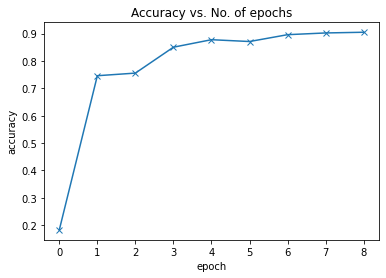

In [28]:
plot_accuracies(history)

As, we can see in the graph, accuracy of the model increases at every epoch except at some point where `max_lr` increased suddenly and decreased since then.

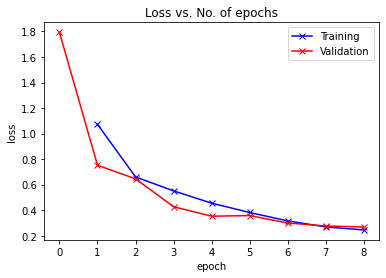

In [29]:
plot_losses(history)

Objective of this model was to `avoid overfitting` which is acheived without a doubt. Training loss and Validation loss both seems at same level. In overfitting, validation loss would have increased after some epoch but training loss would still be decreasing.

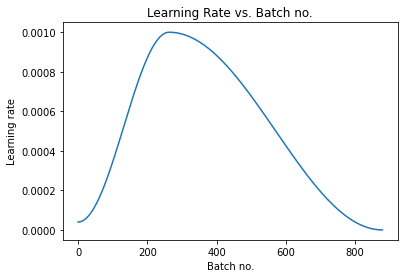

In [30]:
plot_lrs(history)

Here, we can see that `learning rate` increased at the start. And then started to decrease even below when it was started. Model decides `lr` based on how its performing at given lr.

***
# Testing
***

Let's predict some images and see how it performs.

In [31]:
def denormalize_image(img, means, stds):
    means = torch.tensor(means).reshape(3, 1, 1)
    stds = torch.tensor(stds).reshape(3, 1, 1)
    return img * stds + means

def predict_image(img, model):
    xb = to_device(img.unsqueeze(0), device)
    yb = model(xb)
    _, preds  = torch.max(yb, dim=1)
    return train_set.classes[preds[0].item()]

Label: buildings , Predicted: buildings


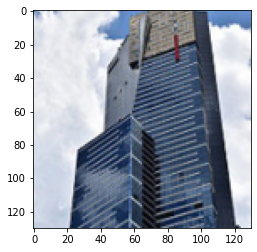

In [32]:
img, label = val_set[0]
plt.imshow(denormalize_image(img, *stats).permute(1, 2, 0).clamp(0, 1))
print('Label:', train_set.classes[label], ', Predicted:', predict_image(img, model))

Label: buildings , Predicted: buildings


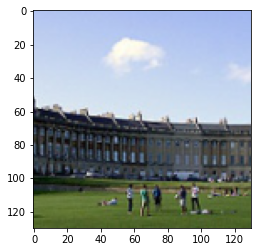

In [33]:
img, label = val_set[109]
plt.imshow(denormalize_image(img, *stats).permute(1, 2, 0).clamp(0, 1))
print('Label:', train_set.classes[label], ', Predicted:', predict_image(img, model))

Label: mountain , Predicted: mountain


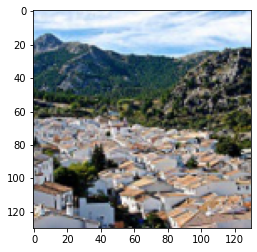

In [34]:
img, label = val_set[1601]
plt.imshow(denormalize_image(img, *stats).permute(1, 2, 0).clamp(0, 1))
print('Label:', train_set.classes[label], ', Predicted:', predict_image(img, model))

Label: sea , Predicted: sea


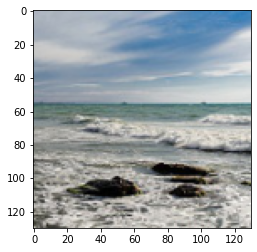

In [35]:
img, label = val_set[2136]
plt.imshow(denormalize_image(img, *stats).permute(1, 2, 0).clamp(0, 1))
print('Label:', train_set.classes[label], ', Predicted:', predict_image(img, model))

Seems like our model is doing pretty good on test images. That's what our objective was !

Let's save the `model parameters` so that we do not have to go through any training phase instead we can use and load prerecorded parameters in another similar model.

In [36]:
torch.save(model.state_dict(), 'deep-learning-course-project-resnet.pth')

Recording all `metrics` and `hyperparameters` ...

In [45]:
jovian.reset()
jovian.log_hyperparams(arch='resnet9', 
                       epochs=epochs, 
                       lr=max_lr, 
                       scheduler='one-cycle', 
                       weight_decay=weight_decay, 
                       grad_clip=grad_clip,
                       opt=opt_func.__name__)

[jovian] Please enter your API key ( from https://jovian.ai/ ):
API KEY: ··········
[jovian] Hyperparams logged.


In [46]:
jovian.log_metrics(val_loss=history[-1]['val_loss'], 
                   val_acc=history[-1]['val_acc'],
                   train_loss=history[-1]['train_loss'],
                   time=train_time)

[jovian] Metrics logged.


In [47]:
project_name

'deep-learning-course-project-resnet'

In [49]:
# Commit and save this notebook to jovian !

jovian.commit(
    project = project_name,
    environment = None,
    outputs = ['deep-learning-course-project-resnet.pth']
)

[jovian] Detected Colab notebook...
[jovian] Uploading colab notebook to Jovian...
[jovian] Uploading additional outputs...
[jovian] Attaching records (metrics, hyperparameters, dataset etc.)
[jovian] Committed successfully! https://jovian.ai/pratikghodke4/deep-learning-course-project-resnet


'https://jovian.ai/pratikghodke4/deep-learning-course-project-resnet'